In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew

import multiprocessing

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', None)

#os.chdir('E:\\Python\\HousesPricing')

In [2]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, LSTM, TimeDistributed, merge, Input, Concatenate, concatenate, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf

Using TensorFlow backend.


### House Prices: Advanced Regression Techniques

In [3]:

def checkDAta(data):
    colsWitNa = []
    for i in range(0, len(data.columns)):
        if data[data.columns[i]].isnull().values.any():
            colsWitNa.extend([data.columns[i]])
    print (colsWitNa)

    
def Error(y, y_pred):
    return(np.mean(abs(y-y_pred)/y))

def rmse(y, y_pred):
    return (np.sqrt(((y-y_pred) ** 2).mean()))


Import data train.csv and test.csv

In [4]:
train= pd.read_csv("train.csv")
test= pd.read_csv("test.csv")
data= pd.concat([train, test], axis=0)

data.loc[(data.PoolQC.isnull()) & (data.PoolArea==0), "PoolQC"]= "None"
temp = data[data.PoolQC.isnull()]
cat= temp.PoolArea.unique()
catmeans= data[["PoolArea", "PoolQC"]].groupby("PoolQC", as_index=False).mean()
for i in range(0, len(cat)):
    tt= data[(data.PoolQC.isnull()) & (data.PoolArea==cat[i])][["PoolArea", "PoolQC"]]
    catmeans["Diff"]= (catmeans.PoolArea- tt.PoolArea.iloc[0]).abs()
    replaceCat= catmeans.PoolQC[catmeans.Diff==catmeans.Diff.min()].iloc[0]
    data.loc[(data.PoolQC.isnull()) & (data.PoolArea == cat[i]), "PoolQC"]= replaceCat

data= data[list(train.columns)]

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [5]:
print("Data shape: " +  str(data.shape))

Data shape: (2919, 81)


In [6]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,NaN,NaN,0,12,2008,WD,Normal,250000.0


Let`s visualize missing values of our data set usind three dimensional array RGB.

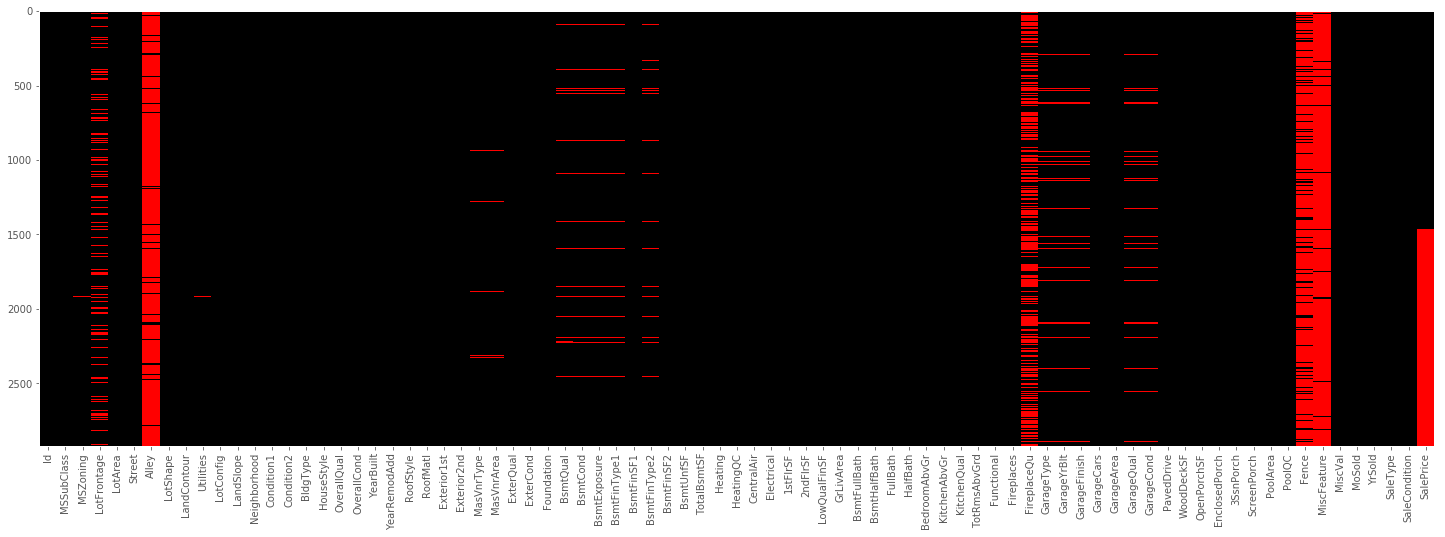

In [7]:
###Prepare data for visualize missing values
dataHeatMap= data.copy()
table = np.ones((dataHeatMap.shape[0], dataHeatMap.shape[1], 3), dtype=np.uint8) * 0

col= dataHeatMap.columns
for i in range(0, len(col)):
    dataHeatMap.loc[~dataHeatMap[col[i]].isnull(), col[i]]=0
dataHeatMap= dataHeatMap.fillna(255)
dataHeatMap= dataHeatMap.values.tolist()

for i in range(0, len(dataHeatMap)):
    table[i, :, 0]= dataHeatMap[i]
    
style.use('ggplot')
f = plt.figure(figsize=(25, 8))
plt.imshow(table, interpolation='none', aspect='auto')
plt.xticks(range(table.shape[1]), data.columns, rotation='vertical')
plt.grid(False)
plt.show()

Let`s fill all missing values for each feachure, using different techniques.

In [8]:
###Fill missing values
data.loc[data.MSZoning.isnull(), "MSZoning"]= data.MSZoning.value_counts().index[0]
data.loc[data.LotFrontage.isnull(), "LotFrontage"]= data.LotFrontage[data.Street=="Pave"].median()
data.loc[data.Alley.isnull(), "Alley"]= "None"
data.loc[data.Utilities.isnull(), "Utilities"]= data.Utilities.value_counts().index[0]
data.loc[data.Exterior1st.isnull(), "Utilities"]= data.Exterior1st.value_counts().index[0]
data.loc[data.Exterior2nd.isnull(), "Utilities"]= data.Exterior2nd.value_counts().index[0]

data.loc[(data.MasVnrType.isnull()) & (data.MasVnrArea.isnull()), "MasVnrType"]= "None"
data.loc[(data.MasVnrArea.isnull()), "MasVnrArea"]= 0
data.loc[(data.MasVnrType.isnull()) & (~data.MasVnrArea.isnull()), "MasVnrType"]= "Stone"

data.loc[(data.BsmtQual.isnull()) & (data.BsmtCond=="Fa"),  "BsmtQual"]= "TA"
data.loc[(data.BsmtQual.isnull()) & (data.BsmtCond=="TA"),  "BsmtQual"]= "TA"
#data= data.dropna(subset=["BsmtFinType1", "BsmtFinSF2", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF"])
data.loc[data.BsmtFinSF2.isnull(), "BsmtFinSF2"]= data.BsmtFinSF2.median()
data.loc[data.BsmtUnfSF.isnull(), "BsmtUnfSF"]= data.BsmtUnfSF.median()
data.loc[data.TotalBsmtSF.isnull(), "TotalBsmtSF"]= data.TotalBsmtSF.median()
data.loc[(data.BsmtFinType1.isnull()) & (data.BsmtCond.isnull()) & (data.BsmtExposure.isnull()),"BsmtFinType1"]= "None"
data.loc[(data.BsmtFinType2.isnull()) & (data.BsmtCond.isnull()) & (data.BsmtExposure.isnull()),"BsmtFinType2"]= "None"
data.loc[(data.BsmtFinType2.isnull()) & (data.BsmtCond=="TA") & (data.BsmtExposure=="No") & (data.BsmtFinType1=="GLQ"),"BsmtFinType2"]= \
    data.loc[ (data.BsmtCond=="TA") & (data.BsmtExposure=="No") & (data.BsmtFinType1=="GLQ")].BsmtFinType2.value_counts().index[0]
#data.loc[(data.BsmtFinSF2.isnull()) & (data.BsmtCond.isnull()) & (data.BsmtExposure.isnull()),"BsmtFinSF2"]= "None"
#data.loc[(data.BsmtUnfSF.isnull()) & (data.BsmtCond.isnull()) & (data.BsmtExposure.isnull()),"BsmtUnfSF"]= "None"
#data.loc[(data.TotalBsmtSF.isnull()) & (data.BsmtCond.isnull()) & (data.BsmtExposure.isnull()),"TotalBsmtSF"]= "None"
data.loc[(data.BsmtQual=="Gd") & (data.BsmtCond.isnull()), "BsmtCond"]= data[data.BsmtQual=="Gd"].BsmtCond.value_counts().index[0]
data.loc[(data.BsmtQual=="TA") & (data.BsmtCond.isnull()), "BsmtCond"]= data[data.BsmtQual=="TA"].BsmtCond.value_counts().index[0]
data.loc[(data.BsmtQual.isnull()) & (data.BsmtCond.isnull()) & (data.BsmtExposure.isnull()), ["BsmtQual", "BsmtCond", "BsmtExposure"]]= "None"
#data.loc[data.BsmtFinType2.isnull(), "BsmtFinType2"]= data[(data.BsmtQual=="Gd") & (data.BsmtCond=="TA") & (data.BsmtExposure=="No") & (data.BsmtFinType1=="GLQ")].BsmtFinType2.value_counts().index[0]
data.loc[data.BsmtExposure.isnull(), "BsmtExposure"]= "None"
data.loc[data.BsmtFinSF1.isnull(), "BsmtFinSF1"]= data.BsmtFinSF1.median()

#data.loc[data.Electrical.isnull(), "Alley"]= "None"

data.loc[data.BsmtFullBath.isnull(), "BsmtFullBath"]= data.BsmtFullBath.value_counts().index[0]
data.loc[data.BsmtHalfBath.isnull(), "BsmtHalfBath"]= data.BsmtHalfBath.value_counts().index[0]

data.loc[data.KitchenQual.isnull(), "KitchenQual"]= data[data.KitchenAbvGr==1].KitchenQual.value_counts().index[0]

data.loc[data.Functional.isnull(), "Functional"]= data.Functional.value_counts().index[0]

data.loc[data.FireplaceQu.isnull(), "FireplaceQu"]= "None"

data.loc[data.GarageArea==0, "GarageType"]= "None"
#data.loc[data.GarageCars==0, "GarageType"]= "None"
data.loc[data.GarageType.isnull(), "GarageType"]= "None"
data.loc[data.GarageArea.isnull(), "GarageArea"]= data[data.GarageType=="Detchd"].GarageYrBlt.value_counts().index[0]
data.loc[data.Exterior1st.isnull(), "Exterior1st"]= data.Exterior1st.value_counts().index[0]
data.loc[data.Exterior2nd.isnull(), "Exterior2nd"]= data.Exterior2nd.value_counts().index[0]
#data.loc[data.MasVnrType.isnull(), "MasVnrType"]= data.MasVnrArea[data.MasVnrType=="Stone"].mean()
#data.loc[data.MasVnrType=="None", "MasVnrArea"]= "None"
data.loc[data.Electrical.isnull(), "Electrical"]= data.Electrical.value_counts().index[0]
data.loc[data.GarageType=="None", "GarageYrBlt"]= "None"
data.loc[data.GarageType=="None", "GarageFinish"]= "None"

data.loc[(data.GarageType=="Detchd") & (data.GarageYrBlt.isnull()), "GarageYrBlt"]= int(data[(data.GarageType=="Detchd")].GarageYrBlt.median())
data.loc[(data.GarageType=="Detchd") & (data.GarageFinish.isnull()), "GarageFinish"]= data[(data.GarageType=="Detchd")].GarageFinish.value_counts().index[0]
data.loc[data.GarageCars.isnull(), "GarageCars"]= int(round(data[(data.GarageType=="Detchd") & (data.GarageFinish=="Unf") ].GarageCars.median()))
data.loc[data.GarageType=="None", "GarageQual"]= "None"
data.loc[(data.GarageType=="Detchd") & (data.GarageYrBlt==1961) & (data.GarageFinish=="Unf"), "GarageQual"]= data[(data.GarageType=="Detchd") & (data.GarageYrBlt==1961) & (data.GarageFinish=="Unf") & (~data.GarageQual.isnull())].GarageQual.value_counts().index[0]
data.loc[data.GarageCond.isnull(), "GarageCond"]= data[(data.GarageType=="Detchd") & (data.GarageYrBlt==1961) & (data.GarageFinish=="Unf") & (~data.GarageCond.isnull()) ].GarageCond.value_counts().index[0]
data.loc[(data.GarageCars==1) & (data.GarageCond=="TA") & (data.GarageFinish=="Unf") & (data.GarageYrBlt==1962) & (data.GarageQual.isnull()), "GarageQual"]= 0

data.loc[data.Fence.isnull(), "Fence"]= "None"
data.loc[data.MiscFeature.isnull(), "MiscFeature"]= "None"

data.loc[data.SaleType.isnull(), "SaleType"]= data.SaleType.value_counts().index[0]


Create and add new features.

Simplifications of existing features

Combinations of existing features

Polynomials on the top n existing features

In [9]:
###Add new variables
# add total area
cols= ["MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", \
       "GrLivArea", "GarageArea", "OpenPorchSF", "3SsnPorch", "EnclosedPorch", "ScreenPorch", "WoodDeckSF"]
totalArea= 0
for i in cols:
    totalArea= totalArea + data[i].astype(int)

data["IsGarage"]= (~(data.GarageType=="None")*1).astype(object)
cols= ["IsGarage", "FullBath", "BsmtFullBath", "BsmtHalfBath", "HalfBath"]
totalRoms= 0
for i in cols:
    totalRoms= totalRoms + data[i].fillna(0)

data["TotalArea"]= totalArea.astype(object)
data["TotalRooms"]= totalRoms.astype(object)


data["IsRegularLotShape"] = ((data["LotShape"] == "Reg") * 1).astype(object)
data["IsAlley"] = ((data["Alley"] != "None") * 1).astype(object)
data["IsMSZoningRL"] = ((data["MSZoning"] == "RL") * 1).astype(object)
data["IsLandSlopeGtl"] = ((data["LandSlope"] == "Gtl") * 1).astype(object)
data["Remodeled"] = ((data["YearRemodAdd"] != data["YearBuilt"]) * 1).astype(object)
data["RecentRemodel"] = ((data["YearRemodAdd"] == data["YrSold"]) * 1).astype(object)
data["IsBsmtCondTa"] = ((data["BsmtCond"] == "TA") * 1).astype(object)
data["IsBsmtFinType2Unf"] = ((data["BsmtFinType2"] == "Unf") * 1).astype(object)
data["IsHeatingGasA"] = ((data["Heating"] == "GasA") * 1).astype(object)
data["VeryNewHouse"] = ((data["YearBuilt"] == data["YrSold"]) * 1).astype(object)
data["IsFireplaces"] = ((data["Fireplaces"] >0) * 1).astype(object)
data["IsPavedDrivePaved"] = ((data["PavedDrive"] == "Y") * 1).astype(object)
data["HasWoodDeck"] = ((data["WoodDeckSF"] == 0) * 1).astype(object)
data["Hs2Floor"] = ((data["2ndFlrSF"] > 0) * 1).astype(object)
data["SoldAtYrBuild"]= ((data.YearBuilt==data.YrSold)*1).astype(object)
data["HighSeason"] = (data["MoSold"].replace( {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})).astype(object)
data["YearsSinceRemodel"] = (data["YrSold"] - data["YearRemodAdd"]).astype(object)
data["Age"] = (2010 - data["YearBuilt"]).astype(object)
data["TotalBath"]= (data.BsmtFullBath+data.BsmtHalfBath+data.FullBath+data.HalfBath).astype(int)
data["IsBath"]= ((data.TotalBath>0)*1).astype(object)
data["IsCars"]= ((data.GarageCars>0)*1).astype(object)

data["Is2ndFloor"] = ((data["2ndFlrSF"] == 0) * 1).astype(object)
data["IsMasVnr"] = ((data["MasVnrArea"] == 0) * 1).astype(object)
data["IsWoodDeck"] = ((data["WoodDeckSF"] == 0) * 1).astype(object)
data["IsOpenPorch"] = ((data["OpenPorchSF"] == 0) * 1).astype(object)
data["IsEnclosedPorch"] = ((data["EnclosedPorch"] == 0) * 1).astype(object)
data["Is3SsnPorch"] = ((data["3SsnPorch"] == 0) * 1).astype(object)
data["IsScreenPorch"] = ((data["ScreenPorch"] == 0) * 1).astype(object)

#data["IsPool"]= ((data.PoolArea>0)*1).astype(object)
#ata["IsFence"]= ((data.Fence!="None")*1).astype(object)
#data["IsBsmt"]= ((data.BsmtQual!="None")*1).astype(object)

data.MoSold= data.MoSold.astype(object)
data.YrSold= data.YrSold.astype(object)


In [10]:
data.MasVnrArea= data.MasVnrArea.astype(int)
data.GarageCars= data.GarageCars.astype(int)
data.GarageArea= data.GarageArea.astype(int)
data.BsmtFinSF1= data.BsmtFinSF1.astype(int)
data.TotalBsmtSF= data.TotalBsmtSF.astype(int)
data.BsmtUnfSF= data.BsmtUnfSF.astype(int)
data.BsmtFinSF2= data.BsmtFinSF2.astype(int)
data.MasVnrArea= data.MasVnrArea.astype(int)
data.LotFrontage= data.LotFrontage.astype(int)
data.TotalArea= data.TotalArea.astype(int)
data.TotalRooms= data.TotalRooms.astype(int)
data.Age= data.Age.astype(int)
data.YearsSinceRemodel= data.YearsSinceRemodel.astype(int)
data.HighSeason= data.HighSeason.astype(int)
data.GrLivArea= data.GrLivArea.astype(int)
data['1stFlrSF']= data['1stFlrSF'].astype(int)
data["2ndFlrSF"]= data["2ndFlrSF"].astype(int)
data.OpenPorchSF= data.OpenPorchSF.astype(int)
data.WoodDeckSF= data.WoodDeckSF.astype(int)
data.FullBath= data.FullBath.astype(int)
data.HalfBath= data.HalfBath.astype(int)
data["SeasonSold"] = data["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)

#data.PavedDrive= data.PavedDrive.astype(int)

In [11]:
data.GarageYrBlt= data.GarageYrBlt.astype(str)
data.GarageYrBlt[data.GarageYrBlt>"2010"]= "2010"
data.GarageYrBlt= data.GarageYrBlt.astype(float).astype(int)
data["GarageOld"]= "old"
data.GarageOld[(data.GarageYrBlt>1920)]= "medium"
data.GarageOld[(data.GarageYrBlt>1995)]= "new"

data["HouseOld"]= "old"
data.HouseOld[data.Age>60]= "medium"
data.HouseOld[data.Age>20]= "new"

In [12]:
# Feature for neighborhood. Create groups for neighborhood
train= data[~data.SalePrice.isnull()]
neighbor= train[["Neighborhood", "SalePrice"]].groupby("Neighborhood", as_index=False).median().sort_values("SalePrice")
neighbor['NeighborhoodBin']= 0

neighbor.NeighborhoodBin[(neighbor.SalePrice>100000)]=1
neighbor.NeighborhoodBin[(neighbor.SalePrice>=140000)]= 2
neighbor.NeighborhoodBin[(neighbor.SalePrice>=200000)]= 3
neighbor.NeighborhoodBin= neighbor.NeighborhoodBin.astype(object)
                          
data= pd.merge(data, neighbor[["Neighborhood", "NeighborhoodBin"]], on= "Neighborhood", how="left")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,IsGarage,TotalArea,TotalRooms,IsRegularLotShape,IsAlley,IsMSZoningRL,IsLandSlopeGtl,Remodeled,RecentRemodel,IsBsmtCondTa,IsBsmtFinType2Unf,IsHeatingGasA,VeryNewHouse,IsFireplaces,IsPavedDrivePaved,HasWoodDeck,Hs2Floor,SoldAtYrBuild,HighSeason,YearsSinceRemodel,Age,TotalBath,IsBath,IsCars,Is2ndFloor,IsMasVnr,IsWoodDeck,IsOpenPorch,IsEnclosedPorch,Is3SsnPorch,IsScreenPorch,SeasonSold,GarageOld,HouseOld,NeighborhoodBin
0,1,60,RL,65,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500.0,1,5787,5,1,0,1,1,0,0,1,1,1,0,0,1,1,1,0,0,5,7,4,1,1,0,0,1,0,1,1,1,0,new,old,2
1,2,20,RL,80,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500.0,1,5522,4,1,0,1,1,0,0,1,1,1,0,1,1,0,0,0,1,31,34,3,1,1,1,1,0,1,1,1,1,1,medium,new,3
2,3,60,RL,68,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500.0,1,5790,5,0,0,1,1,1,0,1,1,1,0,1,1,1,1,0,0,6,9,4,1,1,0,0,1,0,1,1,1,3,new,old,2
3,4,70,RL,60,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000.0,1,5355,3,0,0,1,1,1,0,0,1,1,0,1,1,1,1,0,0,36,95,2,1,1,0,1,1,0,0,1,1,0,new,new,3
4,5,60,RL,84,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000.0,1,7658,5,0,0,1,1,0,0,1,1,1,0,1,1,0,1,0,0,8,10,4,1,1,0,0,0,0,1,1,1,0,new,old,3


Convert cathegorical features to mumerical.

In [13]:
###Cathegory convert to numbers
columnsToInt = ["MSZoning", "Street", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", \
               "Neighborhood",	"Condition1",	"Condition2",	"BldgType",	"HouseStyle" , "RoofStyle", \
               "RoofMatl",	"Exterior1st",	"Exterior2nd",	"MasVnrType", "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", \
               "BsmtFinType2", "Heating", "HeatingQC", "CentralAir", "Electrical", "KitchenQual", "Functional", "GarageType", "GarageFinish", \
               "GarageQual",	"GarageCond",	"PavedDrive", "PoolQC",	"Fence", "MiscFeature", "SaleType", "SaleCondition"]
columnsToInt = data.select_dtypes(include = ["object"]).columns
for i in range(0, len(columnsToInt)):
    tt= pd.DataFrame(data[columnsToInt[i]].value_counts())
    #if len(tt)<2:
    tt["Category"]= tt.index.astype(str)
    tt["CategoryNew"]= range(0, len(tt))
    categories= tt.Category.astype(str)
    for j in categories:
        data.loc[data[columnsToInt[i]] == j, columnsToInt[i]] = tt.CategoryNew[tt.Category == j].iloc[0]
        data[columnsToInt[i]]=data[columnsToInt[i]].astype(object)

In [14]:
tt= data.drop("SalePrice", axis=1)
print("IsNull: "+ str(tt[tt.isnull().any(axis=1)].shape))

IsNull: (0, 115)


In [15]:
categorical = list(data.select_dtypes(include = ["object"]).columns)
numeric = list(data.select_dtypes(exclude = ["object"]).columns)

Remove categorical featirres with unique categories count<2

In [16]:
countUnique = pd.DataFrame(columns=["Feature", "UniqCount"])
for cat in categorical:    
    countUnique = countUnique.append({"Feature":cat, "UniqCount": len(data[cat].value_counts())}, ignore_index=True)
countUnique = countUnique.sort_values("UniqCount")

categorical = countUnique[countUnique.UniqCount>1].Feature.tolist()
data = data.drop(countUnique[countUnique.UniqCount<2].Feature.tolist(), axis=1)

Select numerical features which have correlatin>0.3

In [17]:
###Select numerical features which have correlatin>0.3

def corrCalc(data, target):
    target = "SalePrice"
    result = pd.DataFrame(columns=["Features", "Corr"])
    targtetValues = data[target].values
    columns = data.columns
    for col in columns:
        #if col != target:
        temp = data[col].values
        corr = np.corrcoef(targtetValues, temp)[0][1]
        result = result.append({"Features":col, "Corr":corr}, ignore_index=True)
    return result

corrThreshold = 0.5

train= data[~data.SalePrice.isnull()]
train= train[numeric]
test= data[data.SalePrice.isnull()]
tCorr= train.corr().abs()
#featuresBest= list(tCorr[tCorr.index=="SalePrice"][tCorr.abs()>0.3].dropna(axis=1).columns)
#featuresBest= list(tCorr[tCorr.index=="SalePrice"][tCorr.abs()>corrThreshold].T.sort_values("SalePrice",ascending = False).dropna(axis=1).index)
featuresBest = corrCalc(data=train, target="SalePrice")
featuresBest = featuresBest[featuresBest.Corr.abs()>corrThreshold].Features.tolist()
dataCorrFeatures= data[list(categorical)+list(featuresBest)+list(["Id"])]
print ("Selected: "+str(len(featuresBest))+ " features")

Selected: 16 features


In [18]:
dataCorrFeatures.head()

,Remodeled,IsAlley,RecentRemodel,CentralAir,IsBsmtCondTa,IsBsmtFinType2Unf,IsHeatingGasA,VeryNewHouse,IsFireplaces,IsPavedDrivePaved,HasWoodDeck,IsGarage,SoldAtYrBuild,HouseOld,IsLandSlopeGtl,Hs2Floor,IsMSZoningRL,Is2ndFloor,IsMasVnr,IsWoodDeck,IsOpenPorch,IsEnclosedPorch,Is3SsnPorch,IsScreenPorch,IsCars,Street,IsRegularLotShape,Alley,PavedDrive,Utilities,GarageOld,LandSlope,PoolQC,NeighborhoodBin,KitchenQual,ExterQual,MasVnrType,LandContour,LotShape,GarageFinish,YrSold,MSZoning,BsmtCond,LotConfig,BldgType,ExterCond,BsmtQual,BsmtExposure,HeatingQC,Electrical,GarageCond,Fence,MiscFeature,FireplaceQu,Heating,SaleCondition,GarageQual,Foundation,RoofStyle,BsmtFinType2,BsmtFinType1,GarageType,Functional,RoofMatl,HouseStyle,Condition2,Condition1,SaleType,MoSold,Exterior1st,Exterior2nd,Neighborhood,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice,TotalArea,TotalRooms,YearsSinceRemodel,Age,TotalBath,Id
0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,1,1,0,0,1,0,1,1,1,1,0,1,0,0,0,1,0,0,2,1,1,1,0,0,1,2008,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,2,0,0,1,7,2003,2003,856,856,1710,2,8,2,548,208500.0,5787,5,5,7,4,1
1,0,0,0,0,1,1,1,0,1,1,0,1,0,0,1,0,1,1,1,0,1,1,1,1,1,0,1,0,0,0,0,0,0,3,0,0,0,0,0,1,2007,0,0,3,0,0,1,2,0,0,0,0,0,2,0,0,0,1,0,0,2,0,0,0,0,0,1,0,5,1,1,22,6,1976,1976,1262,1262,1262,2,6,2,460,181500.0,5522,4,31,34,3,2
2,1,0,0,0,1,1,1,0,1,1,1,1,0,1,1,1,1,0,0,1,0,1,1,1,1,0,0,0,0,0,1,0,0,2,1,1,1,0,1,1,2008,0,0,0,0,0,1,3,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,1,0,0,0,9,0,0,1,7,2001,2002,920,920,1786,2,6,2,608,223500.0,5790,5,6,9,4,3
3,1,0,0,0,0,1,1,0,1,1,1,1,0,0,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,0,0,3,1,0,0,0,1,0,2006,0,1,1,0,0,0,0,2,0,0,0,0,1,0,2,0,2,0,0,2,1,0,0,1,0,0,0,2,3,6,12,7,1915,1970,756,961,1717,1,7,3,642,140000.0,5355,3,36,95,2,4
4,0,0,0,0,1,1,1,0,1,1,0,1,0,1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0,0,1,0,0,3,1,1,1,0,1,1,2008,0,0,3,0,0,1,1,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,1,0,0,0,12,0,0,15,8,2000,2000,1145,1145,2198,2,9,3,836,250000.0,7658,5,8,10,4,5


Add polymomial features for numeric features with top 10 correlation

In [19]:
###Add polymomial features for numeric features top 10
train= dataCorrFeatures[~dataCorrFeatures.SalePrice.isnull()]

### Reasign test data
test= dataCorrFeatures[dataCorrFeatures.SalePrice.isnull()]
testId= test.Id

#train= train[numeric]
#tCorr= train.corr().abs()

top10= np.intersect1d(numeric, list(set(featuresBest) - set(["SalePrice", "Id"])))[:10]

for col in top10:
    dataCorrFeatures[col+'2'] = dataCorrFeatures.loc[:,col]**2
    dataCorrFeatures[col+'3'] = dataCorrFeatures.loc[:,col].astype(float)**3
    dataCorrFeatures[col+'Sqrt'] = np.sqrt(np.absolute(dataCorrFeatures.loc[:,col])+1)


Let`s check our data set again for missing values, using visualization technique that i used before.

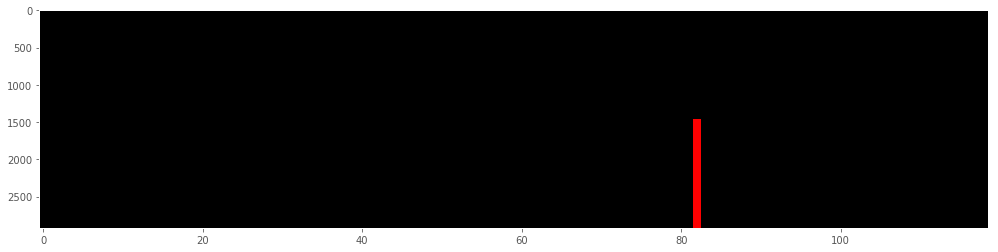

Features with Nans: 0


In [20]:
###Check missing values
###Prepare datadataCorrFeaturesfor visualize missing values
dataHeatMap= dataCorrFeatures.copy()
table = np.ones((dataHeatMap.shape[0], dataHeatMap.shape[1], 3), dtype=np.uint8) * 0

col= dataHeatMap.columns
for i in range(0, len(col)):
    dataHeatMap.loc[~dataHeatMap[col[i]].isnull(), col[i]]=0
dataHeatMap= dataHeatMap.fillna(255)
dataHeatMap= dataHeatMap.values.tolist()

for i in range(0, len(dataHeatMap)):
    table[i, :, 0]= dataHeatMap[i]
    
style.use('ggplot')
f = plt.figure(figsize=(17, 4))
plt.imshow(table, interpolation='none', aspect='auto')
#plt.xticks(range(table.shape[1]), data.columns, rotation='vertical')
plt.grid(False)
plt.show()
print("Features with Nans: " + str(data.drop("SalePrice", axis=1).isnull().values.sum()))

Check for the skeweness.

Log transform of the skewed numerical features to lessen impact of outliers

In [21]:
### Check skewenss

numeric = list(dataCorrFeatures.select_dtypes(exclude = ["object"]).columns)
skewdValue = 1.0

skewed = dataCorrFeatures[list(numeric)].apply(lambda x: skew(x.dropna().astype(float)))
data2= dataCorrFeatures.copy()
skewdCols= [x for x in skewed.index if (x not in ["Id", "SalePrice"]) and (np.abs(skewed[x])>skewdValue)]
print("Number of skewed columns > "+str(skewdValue)+" = "+ str(len(skewdCols)))
skewed= skewed[skewdCols]
data2[skewed[skewed.abs()>skewdValue].index]= np.log1p(data2[skewed[skewed.abs()>skewdValue].index])

train= data2[~data2.SalePrice.isnull()]
test= data2[data2.SalePrice.isnull()]

corr2= tCorr.copy()
hh= corr2.columns
k= []
for i in range(0, len(hh)):
    if not sum(((corr2[corr2.index!=hh[i]][hh[i]]<skewdValue)==0)*1):
        k.extend([hh[i]])

#train= train[train.SalePrice< train.SalePrice.quantile(.99)]
features= data2.columns.drop("SalePrice")
###check Nans in features train
for i in features:
    tt= train[train[i].isnull()]
    if len(tt)>0:
        print (i)
        train[i]=train[i].fillna(train[i].median())
        
###check Nans in features test
for i in features:
    tt= test[test[i].isnull()]
    if len(tt)>0:
        print (i)
        test[i]=test[i].fillna(test[i].median())
        
dataCorrFeaturesUnSkew= pd.concat([train, test], axis=0)

Number of skewed columns > 1.0 = 24


Create dummy features for categorical values 

In [22]:
###Create dummy varibles for categorical features
cat= np.intersect1d(dataCorrFeaturesUnSkew.columns, categorical)
dataCat= dataCorrFeaturesUnSkew[categorical]
dataCat = pd.get_dummies(dataCat)
dataNum = dataCorrFeaturesUnSkew[numeric]
dataNew= pd.concat([dataNum, dataCat], axis=1)

In [23]:
train= dataNew[~dataNew.SalePrice.isnull()]
y= train.SalePrice
train= train.drop("SalePrice", axis=1)
test= dataNew[dataNew.SalePrice.isnull()]
test= test.drop("SalePrice", axis=1)
testId= test.Id
train= train.drop("Id", axis=1)
test= test.drop("Id", axis=1)

In [24]:
print("Train " +str(train.shape))
print ("Test " +str(test.shape))

Train (1460, 385)
Test (1459, 385)


In [25]:
tt= dataNew.drop("SalePrice", axis=1)
tt[tt.isnull().any(axis=1)]

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,TotalArea,TotalRooms,YearsSinceRemodel,Age,TotalBath,Id,1stFlrSF2,1stFlrSF3,1stFlrSFSqrt,Age2,Age3,AgeSqrt,FullBath2,FullBath3,FullBathSqrt,GarageArea2,GarageArea3,GarageAreaSqrt,GarageCars2,GarageCars3,GarageCarsSqrt,GrLivArea2,GrLivArea3,GrLivAreaSqrt,OverallQual2,OverallQual3,OverallQualSqrt,TotRmsAbvGrd2,TotRmsAbvGrd3,TotRmsAbvGrdSqrt,TotalArea2,TotalArea3,TotalAreaSqrt,TotalBath2,TotalBath3,TotalBathSqrt,Remodeled_0,Remodeled_1,IsAlley_0,IsAlley_1,RecentRemodel_0,RecentRemodel_1,CentralAir_0,CentralAir_1,IsBsmtCondTa_0,IsBsmtCondTa_1,IsBsmtFinType2Unf_0,IsBsmtFinType2Unf_1,IsHeatingGasA_0,IsHeatingGasA_1,VeryNewHouse_0,VeryNewHouse_1,IsFireplaces_0,IsFireplaces_1,IsPavedDrivePaved_0,IsPavedDrivePaved_1,HasWoodDeck_0,HasWoodDeck_1,IsGarage_0,IsGarage_1,SoldAtYrBuild_0,SoldAtYrBuild_1,HouseOld_0,HouseOld_1,IsLandSlopeGtl_0,IsLandSlopeGtl_1,Hs2Floor_0,Hs2Floor_1,IsMSZoningRL_0,IsMSZoningRL_1,Is2ndFloor_0,Is2ndFloor_1,IsMasVnr_0,IsMasVnr_1,IsWoodDeck_0,IsWoodDeck_1,IsOpenPorch_0,IsOpenPorch_1,IsEnclosedPorch_0,IsEnclosedPorch_1,Is3SsnPorch_0,Is3SsnPorch_1,IsScreenPorch_0,IsScreenPorch_1,IsCars_0,IsCars_1,Street_0,Street_1,IsRegularLotShape_0,IsRegularLotShape_1,Alley_0,Alley_1,Alley_2,PavedDrive_0,PavedDrive_1,PavedDrive_2,Utilities_0,Utilities_1,Utilities_2,GarageOld_0,GarageOld_1,GarageOld_2,LandSlope_0,LandSlope_1,LandSlope_2,PoolQC_0,PoolQC_1,PoolQC_2,PoolQC_3,NeighborhoodBin_0,NeighborhoodBin_1,NeighborhoodBin_2,NeighborhoodBin_3,KitchenQual_0,KitchenQual_1,KitchenQual_2,KitchenQual_3,ExterQual_0,ExterQual_1,ExterQual_2,ExterQual_3,MasVnrType_0,MasVnrType_1,MasVnrType_2,MasVnrType_3,LandContour_0,LandContour_1,LandContour_2,LandContour_3,LotShape_0,LotShape_1,LotShape_2,LotShape_3,GarageFinish_0,GarageFinish_1,GarageFinish_2,GarageFinish_3,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MSZoning_0,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,BsmtCond_0,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtCond_4,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,BldgType_0,BldgType_1,BldgType_2,BldgType_3,BldgType_4,ExterCond_0,ExterCond_1,ExterCond_2,ExterCond_3,ExterCond_4,BsmtQual_0,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,BsmtExposure_0,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,HeatingQC_0,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,Electrical_0,Electrical_1,Electrical_2,Electrical_3,Electrical_4,GarageCond_0,GarageCond_1,GarageCond_2,GarageCond_3,GarageCond_4,Fence_0,Fence_1,Fence_2,Fence_3,Fence_4,MiscFeature_0,MiscFeature_1,MiscFeature_2,MiscFeature_3,MiscFeature_4,FireplaceQu_0,FireplaceQu_1,FireplaceQu_2,FireplaceQu_3,FireplaceQu_4,FireplaceQu_5,Heating_0,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,GarageQual_0,GarageQual_1,GarageQual_2,GarageQual_3,GarageQual_4,GarageQual_5,Foundation_0,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,RoofStyle_0,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,BsmtFinType2_0,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_4,BsmtFinType2_5,BsmtFinType2_6,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_4,BsmtFinType1_5,BsmtFinType1_6,GarageType_0,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,Functional_0,Functional_1,Functional_2,Functional_3,Functional_4,Functional_5,Functional_6,RoofMatl_0,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_7,HouseStyle_0,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,Condition2_0,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,Condition1_0,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,SaleType_0,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5

In [26]:
stdSc = StandardScaler()
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

Partition the dataset in train and validation sets.

Use random forest for x_train and apply it on x_test? and check how it works.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=0)

print("X_train: " + str(X_train.shape))
print("X_test: " + str(X_test.shape))

X_train: (1022, 385)
X_test: (438, 385)


### Random Forest

<hr>

In [255]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


n_estimators = number of trees in the foreset

max_features = max number of features considered for splitting a node

max_depth = max number of levels in each decision tree

min_samples_split = min number of data points placed in a node before the node is split

min_samples_leaf = min number of data points allowed in a leaf node

bootstrap = method for sampling data points (with or without replacement)

In [256]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


On each iteration, the algorithm will choose a difference combination of the features. 

Altogether, there are 2 * 12 * 2 * 3 * 3 * 10 = 4320 settings! 

However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

In [257]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = cores-1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  25 out of  30 | elapsed:  1.0min remaining:   12.5s
[Parallel(n_jobs=11)]: Done  30 out of  30 | elapsed:  1.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, 

and cv which is the number of folds to use for cross validation (we use 100 and 3 respectively).

More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, 

but raising each will increase the run time. Machine learning is a field of trade-offs, and performance vs time is one of the most fundamental.

In [258]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

In [259]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))

    print ("RMSE: " + str(rmse(np.log(test_labels), np.log(predictions))))
    print ("MSE: " + str(Error(test_labels, predictions)))
    
    return predictions

In [260]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_result = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 18827.7669 degrees.
RMSE: 0.14841154116418168
MSE: 0.10674380358049966


In [261]:
best_optimized = rf_random.best_estimator_
optimized_result = evaluate(best_optimized, X_test, y_test)

Model Performance
Average Error: 16693.4225 degrees.
RMSE: 0.1352487728924934
MSE: 0.09467117744454892


In [264]:
### Feature importance top 30 base_model
#from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(X_train.columns, base_model.feature_importances_), key=lambda x: x[1] * -1)
importance = pd.DataFrame(values)
importance.columns= ["Feature", "Value"]
#print(tabulate(values, headers, tablefmt="plain"))


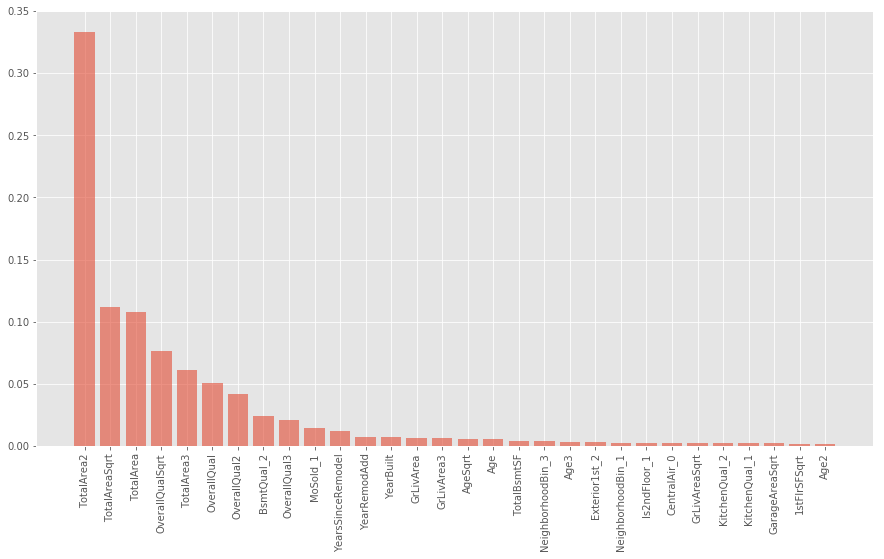

In [265]:
importance2= importance.head(30)
x= range(0, len(importance2.Feature))
plt.figure(figsize=(15, 8))
plt.subplot(111)
plt.bar(x, importance2.Value, align='center', alpha=0.6)
plt.xticks(x, importance2.Feature,  rotation='vertical')
plt.show()

Use fitted model to predict test test.

In [270]:
###Predict test set
# save results

pred = best_optimized.predict(test)

print ("R2 test: " + str(rf_random.score(train, y)))

testFinal= test.copy()
testFinal["SalePrice"]= pred
testFinal["Id"]= testId

testFinal[["Id", "SalePrice"]].to_csv("TestPrediction_Opt.csv", index=False)

R2 test: 0.9351943716043463


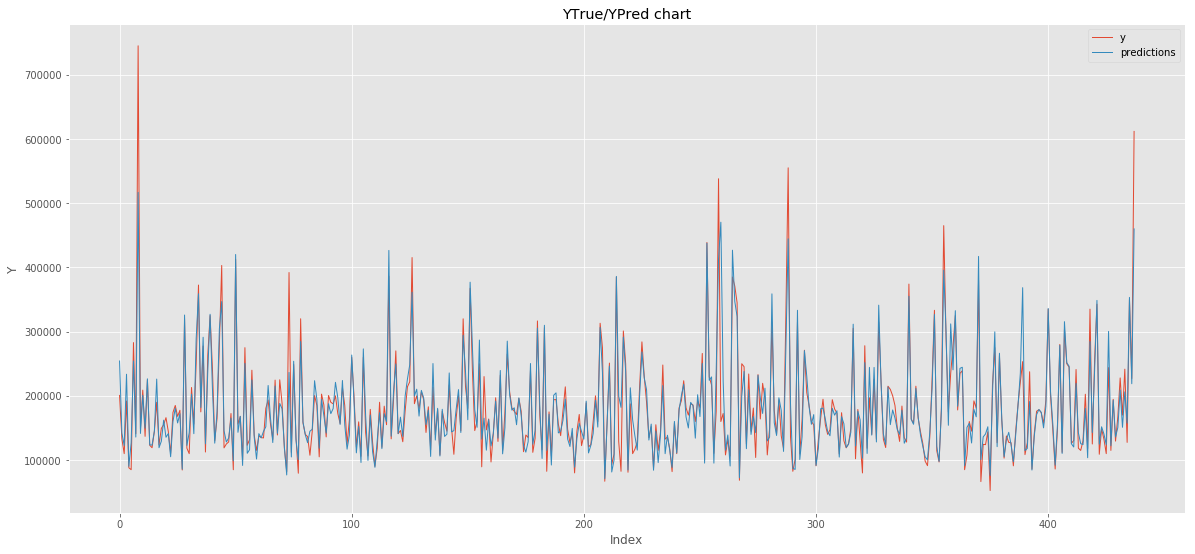

In [296]:
pred_t = best_optimized.predict(X_test)

f = plt.figure(figsize=(20,9))
ax1 = f.add_subplot(111)
ax1.plot(y_test.values, linewidth=1, label="y")
ax1.plot(pred_t, linewidth=1, label="predictions")
ax1.set_xlabel('Index')
ax1.set_ylabel('Price')
ax1.set_title("YTrue/YPred chart")
ax1.legend()
ax1.grid(True)

### xgboost

<hr>

In [274]:
from xgboost import XGBRegressor

In [275]:
# A parameter grid for XGBoost
n_estimators = list(np.arange(100, 1000, 100))
max_features = ['auto', 'sqrt']
max_depth =  list(np.arange(300, 400, 20))

random_grid_GB = {
                'objective':['reg:linear'],
                'learning_rate' : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
                'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_child_weight': [1, 5, 10],
                'gamma': [0.5, 1, 1.5, 2, 5],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]
}
pprint(random_grid_GB)

{'colsample_bytree': [0.6, 0.8, 1.0],
 'gamma': [0.5, 1, 1.5, 2, 5],
 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
 'max_depth': [300, 320, 340, 360, 380],
 'max_features': ['auto', 'sqrt'],
 'min_child_weight': [1, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900],
 'objective': ['reg:linear'],
 'subsample': [0.6, 0.8, 1.0]}


In [276]:
gb = XGBRegressor()
gb_optimized = RandomizedSearchCV(estimator = gb, param_distributions = random_grid_GB, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = cores-1)
gb_optimized.fit(X_train, y_train)

print(gb_optimized.best_score_)
print(gb_optimized.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  25 out of  30 | elapsed:  1.6min remaining:   18.8s
[Parallel(n_jobs=11)]: Done  30 out of  30 | elapsed:  1.7min finished


[13:01:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8619174894361565
{'subsample': 0.6, 'objective': 'reg:linear', 'n_estimators': 500, 'min_child_weight': 10, 'max_features': 'sqrt', 'max_depth': 360, 'learning_rate': 0.1, 'gamma': 2, 'colsample_bytree': 0.6}


In [277]:
base_gb_model = XGBRegressor(n_estimators = 10, random_state = 42)
base_gb_model.fit(X_train, y_train)
base_gb_result = evaluate(base_gb_model, X_test, y_test)

[13:01:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model Performance
Average Error: 64911.9144 degrees.
RMSE: 0.4478973723141532
MSE: 0.33894186545160815


In [278]:
gb_optimized.best_params_

{'subsample': 0.6,
 'objective': 'reg:linear',
 'n_estimators': 500,
 'min_child_weight': 10,
 'max_features': 'sqrt',
 'max_depth': 360,
 'learning_rate': 0.1,
 'gamma': 2,
 'colsample_bytree': 0.6}

In [279]:
best_gb_optimized = gb_optimized.best_estimator_
optimized_gb_result = evaluate(best_gb_optimized, X_test, y_test)

Model Performance
Average Error: 17265.5933 degrees.
RMSE: 0.12909400800728796
MSE: 0.09439519533346385


In [280]:
###Predict test set
# save results

pred = best_gb_optimized.predict(test)

print ("R2 test: " + str(best_gb_optimized.score(train, y)))

testFinal= test.copy()
testFinal["SalePrice"]= pred
testFinal["Id"]= testId

testFinal[["Id", "SalePrice"]].to_csv("TestPrediction_gb_Opt.csv", index=False)

R2 test: 0.9594582889188704


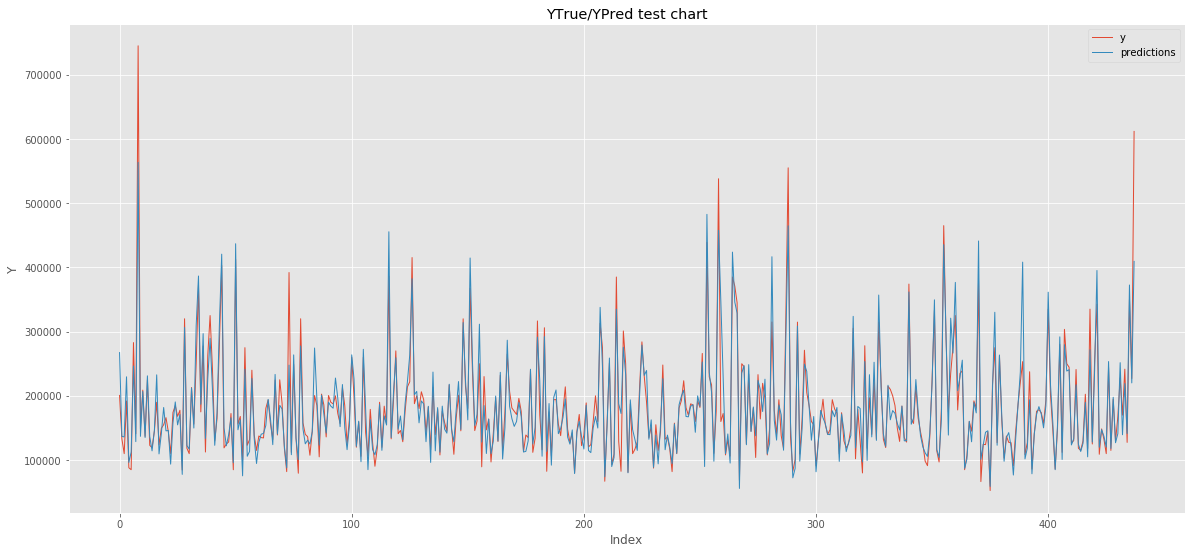

In [295]:
pred_t = best_gb_optimized.predict(X_test)

f = plt.figure(figsize=(20,9))
ax1 = f.add_subplot(111)
ax1.plot(y_test.values, linewidth=1, label="y")
ax1.plot(pred_t, linewidth=1, label="predictions")
ax1.set_xlabel('Index')
ax1.set_ylabel('Price')
ax1.set_title("YTrue/YPred test chart")
ax1.legend()
ax1.grid(True)

### xgboost

Filter features.

Use top n most importatnt features form RF results.

In [283]:

topImportant = importance.Feature.head(250).tolist()

X_train2 = X_train[topImportant]
X_test2 = X_test[topImportant]
gb2 = XGBRegressor()
gb_optimized2 = RandomizedSearchCV(estimator = gb2, param_distributions = random_grid_GB, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = cores-1)
gb_optimized2.fit(X_train2, y_train)

print(gb_optimized2.best_score_)
print(gb_optimized2.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  25 out of  30 | elapsed:  1.1min remaining:   13.6s
[Parallel(n_jobs=11)]: Done  30 out of  30 | elapsed:  1.2min finished


[13:06:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8640108378206304
{'subsample': 0.6, 'objective': 'reg:linear', 'n_estimators': 100, 'min_child_weight': 1, 'max_features': 'sqrt', 'max_depth': 340, 'learning_rate': 0.1, 'gamma': 2, 'colsample_bytree': 0.6}


In [284]:
base_gb_model2 = XGBRegressor(n_estimators = 10, random_state = 42)
base_gb_model2.fit(X_train2, y_train)
base_gb_result2 = evaluate(base_gb_model2, X_test2, y_test)

[13:07:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model Performance
Average Error: 64822.7696 degrees.
RMSE: 0.44721273325478567
MSE: 0.338610027356076


In [285]:
gb_optimized2.best_params_

{'subsample': 0.6,
 'objective': 'reg:linear',
 'n_estimators': 100,
 'min_child_weight': 1,
 'max_features': 'sqrt',
 'max_depth': 340,
 'learning_rate': 0.1,
 'gamma': 2,
 'colsample_bytree': 0.6}

In [286]:
best_gb_optimized2 = gb_optimized2.best_estimator_
optimized_gb_result2 = evaluate(best_gb_optimized2, X_test2, y_test)

Model Performance
Average Error: 16972.5996 degrees.
RMSE: 0.13098751778630394
MSE: 0.09576862640886488


In [ ]:
###Predict test set
# save results

pred = best_gb_optimized2.predict(test)

print ("R2 test: " + str(best_gb_optimized2.score(train, y)))

testFinal= test.copy()
testFinal["SalePrice"]= pred
testFinal["Id"]= testId

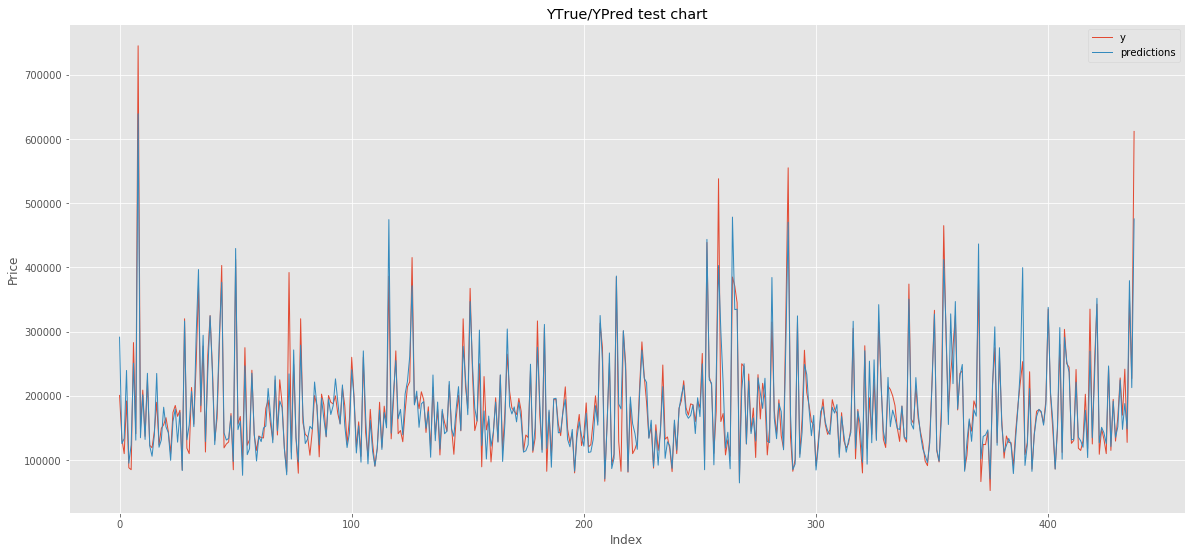

In [298]:
pred_t = best_gb_optimized2.predict(X_test2)

f = plt.figure(figsize=(20,9))
ax1 = f.add_subplot(111)
ax1.plot(y_test.values, linewidth=1, label="y")
ax1.plot(pred_t, linewidth=1, label="predictions")
ax1.set_xlabel('Index')
ax1.set_ylabel('Price')
ax1.set_title("YTrue/YPred test chart")
ax1.legend()
ax1.grid(True)

### Neural networks

Will use DNN architecture

<hr>

In [229]:
from sklearn import preprocessing
from datetime import datetime

x = train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_fit = min_max_scaler.fit(x)
train_NN = pd.DataFrame(min_max_scaler.transform(x))
test_NN = pd.DataFrame(min_max_scaler.transform(test.values))

X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(train_NN, y, test_size=0.3, random_state=0)

print("X_train: " + str(X_train.shape))
print("X_test: " + str(X_test.shape))

X_train: (1022, 385)
X_test: (438, 385)


In [245]:

def custom_loss(y_true, y_pred):
    loss = keras.losses.mean_absolute_percentage_error(y_true, y_pred)
    loss = K.mean(K.abs((y_true-y_pred))/y_true)
    #loss = keras.losses.binary_crossentropy(y_true, y_pred_Pecetile)
    return loss


def custom_loss2(y_true, y_pred):
    loss = K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

    return loss


hudnn1 = 200

loss = custom_loss2
optimizer = 'adam' #rmsprop
act1 = 'relu'

batch_size = 100
epochs = 5000
do = 0.5
earlyStop = 10
min_delta=0.01


print('Training hidden units. Using target: {}'.format(hudnn1))


dnnInput = Input(shape=(X_train.shape[1],), name='dnn_input')

dnnModel = Dense(hudnn1, activation=act1, name="Dense_Layer")(dnnInput)
dnnModel = Dropout(do)(dnnModel)

dnnModel = Dense(hudnn1, activation=act1, name="Dense_Layer2")(dnnModel)
dnnModel = Dropout(do)(dnnModel)

#dnnModel = Dense(500, activation=act1, name="Dense_Layer3")(dnnModel)
#dnnModel = Dropout(do)(dnnModel)

#dnnModel = Dense(500, activation=act1, name="Dense_Layer4")(dnnModel)
#dnnModel = Dropout(do)(dnnModel)

dnnModel = Dense(100, activation=act1, name="Dense_Layer5")(dnnModel)
dnnModel = Dropout(do)(dnnModel)

dnnOut = Dense(1, name="Dense_Out_layer")(dnnModel)


modelAll = Model(inputs=[dnnInput], outputs=dnnOut)

print(modelAll.summary())
modelAll.compile(loss = loss, optimizer = optimizer, metrics=['mean_absolute_percentage_error'])


st = datetime.now()
history = modelAll.fit(X_train_NN.values, y_train_NN.values, batch_size=batch_size,
                              epochs=epochs,
                              validation_data = (X_test_NN.values, y_test_NN.values),
                              verbose=1,
                            callbacks=[
                                EarlyStopping(monitor='val_loss', mode='min', patience=earlyStop, min_delta=min_delta, verbose=1)
                            ])


print("Done")
print("Time: " + str(datetime.now() - st))

Training hidden units. Using target: 200
model_relu_0.5_200_7200.hdf5
Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_input (InputLayer)       (None, 385)               0         
_________________________________________________________________
Dense_Layer (Dense)          (None, 500)               193000    
_________________________________________________________________
dropout_105 (Dropout)        (None, 500)               0         
_________________________________________________________________
Dense_Layer2 (Dense)         (None, 500)               250500    
_________________________________________________________________
dropout_106 (Dropout)        (None, 500)               0         
_________________________________________________________________
Dense_Layer5 (Dense)         (None, 100)               50100     
______________________________________________________

Epoch 34/5000
1022/1022 [==============================] - 0s 156us/step - loss: 33243.6842 - mean_absolute_percentage_error: 17.9730 - val_loss: 25387.4413 - val_mean_absolute_percentage_error: 12.9212
Epoch 35/5000
1022/1022 [==============================] - 0s 143us/step - loss: 32761.4995 - mean_absolute_percentage_error: 18.0479 - val_loss: 25436.8491 - val_mean_absolute_percentage_error: 12.2699
Epoch 36/5000
1022/1022 [==============================] - 0s 142us/step - loss: 33419.4422 - mean_absolute_percentage_error: 17.8005 - val_loss: 24686.7081 - val_mean_absolute_percentage_error: 12.2639
Epoch 37/5000
1022/1022 [==============================] - 0s 142us/step - loss: 33539.4755 - mean_absolute_percentage_error: 18.2526 - val_loss: 24540.1980 - val_mean_absolute_percentage_error: 12.1034
Epoch 38/5000
1022/1022 [==============================] - 0s 143us/step - loss: 32326.7257 - mean_absolute_percentage_error: 17.6652 - val_loss: 24334.2447 - val_mean_absolute_percentage_

1022/1022 [==============================] - 0s 142us/step - loss: 30035.7152 - mean_absolute_percentage_error: 16.8317 - val_loss: 22056.9416 - val_mean_absolute_percentage_error: 11.5673
Epoch 75/5000
1022/1022 [==============================] - 0s 141us/step - loss: 28940.6218 - mean_absolute_percentage_error: 16.1316 - val_loss: 20780.6851 - val_mean_absolute_percentage_error: 11.0674
Epoch 76/5000
1022/1022 [==============================] - 0s 137us/step - loss: 29116.1021 - mean_absolute_percentage_error: 16.3316 - val_loss: 21632.6850 - val_mean_absolute_percentage_error: 11.2912
Epoch 77/5000
1022/1022 [==============================] - 0s 140us/step - loss: 29822.6440 - mean_absolute_percentage_error: 16.5151 - val_loss: 20601.0225 - val_mean_absolute_percentage_error: 10.9715
Epoch 78/5000
1022/1022 [==============================] - 0s 143us/step - loss: 29559.2043 - mean_absolute_percentage_error: 16.6380 - val_loss: 20796.2014 - val_mean_absolute_percentage_error: 10.8691

1022/1022 [==============================] - 0s 139us/step - loss: 28961.4545 - mean_absolute_percentage_error: 16.3371 - val_loss: 19523.0151 - val_mean_absolute_percentage_error: 10.5315
Epoch 115/5000
1022/1022 [==============================] - 0s 138us/step - loss: 29411.1700 - mean_absolute_percentage_error: 16.3060 - val_loss: 19864.3344 - val_mean_absolute_percentage_error: 10.6005
Epoch 116/5000
1022/1022 [==============================] - 0s 147us/step - loss: 28509.5218 - mean_absolute_percentage_error: 15.7242 - val_loss: 19522.9154 - val_mean_absolute_percentage_error: 10.4166
Epoch 117/5000
1022/1022 [==============================] - 0s 137us/step - loss: 28957.4715 - mean_absolute_percentage_error: 15.8762 - val_loss: 19873.0771 - val_mean_absolute_percentage_error: 10.5315
Epoch 118/5000
1022/1022 [==============================] - 0s 137us/step - loss: 29074.3529 - mean_absolute_percentage_error: 16.2791 - val_loss: 19395.6344 - val_mean_absolute_percentage_error: 10.

1022/1022 [==============================] - 0s 141us/step - loss: 27728.2430 - mean_absolute_percentage_error: 15.3231 - val_loss: 19495.4515 - val_mean_absolute_percentage_error: 10.6378
Epoch 155/5000
1022/1022 [==============================] - 0s 142us/step - loss: 28411.0267 - mean_absolute_percentage_error: 15.8866 - val_loss: 19508.7502 - val_mean_absolute_percentage_error: 10.6736
Epoch 00155: early stopping
Done
Time: 0:00:29.752281


In [246]:
def evaluateNN(model, test_features, test_labels):
    predictions = model.predict(test_features).ravel()
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))

    print ("RMSE: " + str(rmse(np.log(test_labels), np.log(predictions))))
    print ("MSE: " + str(Error(test_labels, predictions)))
    
    return predictions

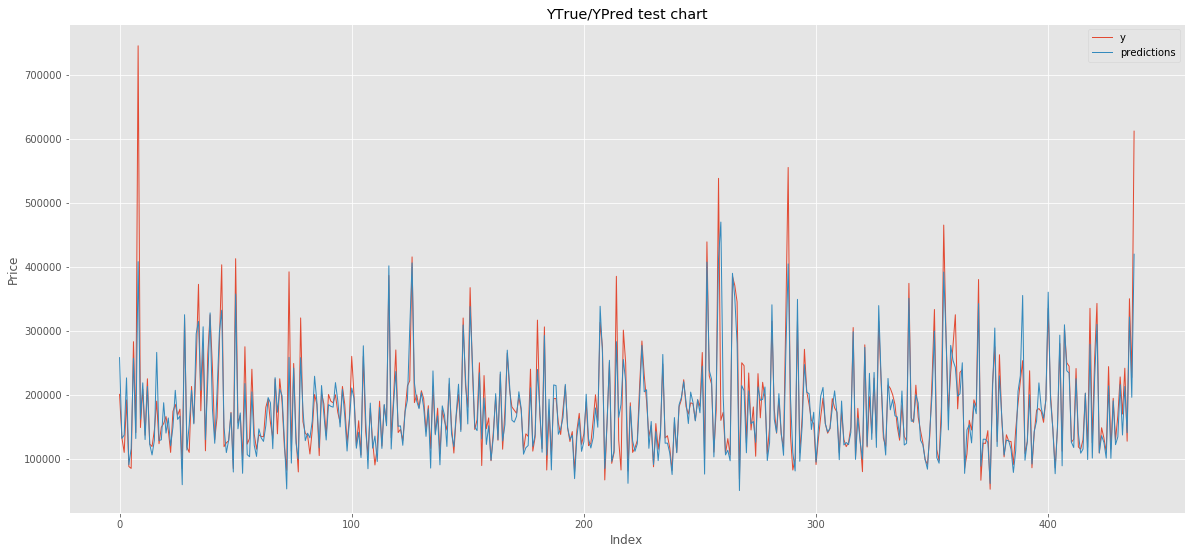

In [299]:
predictions_t = modelAll.predict(X_test_NN).ravel()


f = plt.figure(figsize=(20,9))
ax1 = f.add_subplot(111)
ax1.plot(y_test_NN.values, linewidth=1, label="y")
ax1.plot(predictions_t, linewidth=1, label="predictions")
ax1.set_xlabel('Index')
ax1.set_ylabel('Price')
ax1.set_title("YTrue/YPred test chart")
ax1.legend()
ax1.grid(True)

In [248]:
nn_res = evaluateNN(modelAll, X_test_NN, y_test_NN)

Model Performance
Average Error: 19508.7510 degrees.
RMSE: 0.14759212970489968
MSE: 0.10673614548023275


In [223]:
predictions = modelAll.predict(test_NN).ravel()
testFinal= test_NN.copy()
testFinal["SalePrice"]= predictions
testFinal["Id"]= testId.tolist()

testFinal[["Id", "SalePrice"]].to_csv("TestPrediction_NN_Opt.csv", index=False)


The best result was achived with hight **n_iter** and **epochs** parameters values.
